In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

2024-05-12 17:37:21.380594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 17:37:21.380824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 17:37:21.566417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/bbc-full-text-document-classification/bbc_data.csv")
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [3]:
df.isnull().sum()

data      0
labels    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df['labels'].value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

# Preprocess

In [6]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text
    

In [7]:
df['data_cleaned'] = df['data'].apply(data_cleaning)

# CountVectorizer & ANN

In [8]:
X = df['data_cleaned']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
vect = CountVectorizer()
vect.fit(df['data_cleaned'])

X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

In [10]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [11]:
y_train[:2]

,business,entertainment,politics,sport,tech
126,0,1,0,0,0
1883,0,0,0,0,1


In [12]:
def initialize_model(input):
    input = tf.keras.Input(shape=(input,))

    x = Dense(8, activation='relu')(input)
    x = Dropout(0.2)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = tf.keras.Model(input, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

CountVectorizer_ANN = initialize_model(X_train.shape[1])

In [13]:
history = CountVectorizer_ANN.fit(X_train, y_train, validation_split=0.2, epochs=15)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5046 - loss: 1.3444 - val_accuracy: 0.9270 - val_loss: 0.6298
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8625 - loss: 0.5123 - val_accuracy: 0.9579 - val_loss: 0.3730
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9303 - loss: 0.2915 - val_accuracy: 0.9522 - val_loss: 0.2867
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9301 - loss: 0.2290 - val_accuracy: 0.9551 - val_loss: 0.2435
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9596 - loss: 0.1796 - val_accuracy: 0.9607 - val_loss: 0.2238
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9588 - loss: 0.1488 - val_accuracy: 0.9579 - val_loss: 0.2034
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9558 - loss: 0.1228 - val_accuracy: 0.9579 - val_loss: 0.1933
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9537 - loss: 0.1319 - val_accuracy: 0.9635 - v

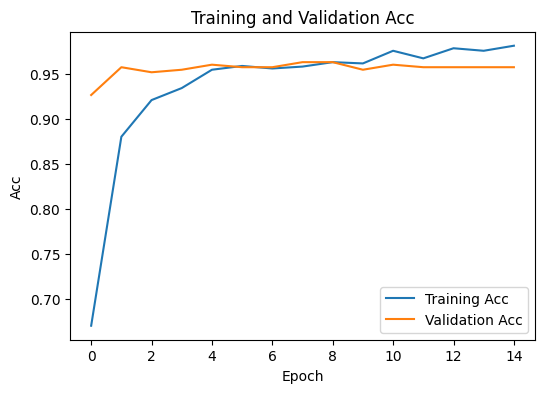

In [14]:
def plot_training_accuracy(history):
    plt.figure(figsize=(6, 4))

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(train_acc))

    plt.plot(epochs, train_acc, label="Training Acc")
    plt.plot(epochs, val_acc, label="Validation Acc")

    plt.title("Training and Validation Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()
    
plot_training_accuracy(history)

In [15]:
pred = CountVectorizer_ANN.predict(X_test)
pred[:1]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[1.3976030e-07, 5.0615700e-08, 9.9999958e-01, 1.0323860e-09,
        1.4879167e-07]], dtype=float32)

Select the class with the highest probability as the predicted outcome

In [16]:
y_pred = np.argmax(pred, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

0.9617977528089887


Lets Examine the first 10 predicted and true test labels for evaluation

In [17]:
label_map = {0:'entertainment', 1:'business', 2:'sport', 3:'politics', 4:'tech'}

# Map ndarray elements to labels
pred_labels = [label_map[val] for val in y_pred[:10]]
true_labels = [label_map[val] for val in y_test[:10]]

print("pred_labels:", pred_labels)
print("true_labels:", true_labels)

pred_labels: ['sport', 'business', 'tech', 'business', 'entertainment', 'business', 'business', 'sport', 'tech', 'tech']
true_labels: ['sport', 'business', 'tech', 'business', 'entertainment', 'business', 'business', 'sport', 'tech', 'tech']


All first 10 samples are correctly classified.

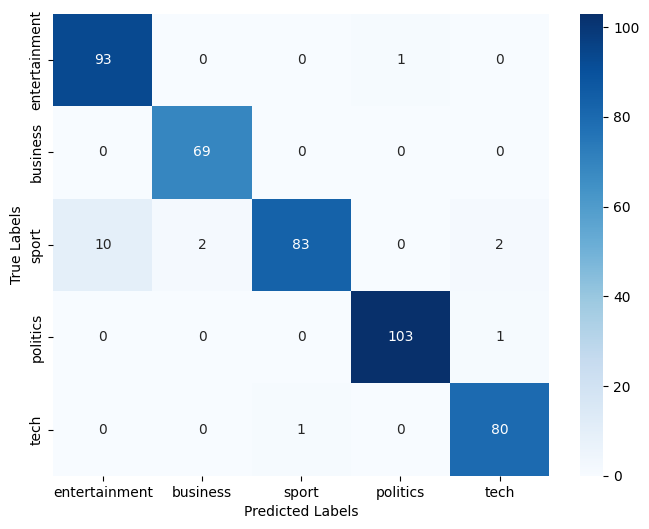

In [18]:
class_labels = ['entertainment', 'business','sport','politics','tech']

conf_matrix = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# TfidfVectorizer & ANN

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
tfid = TfidfVectorizer()

tfid.fit(X)

X_train = tfid.transform(X_train).toarray()
X_test = tfid.transform(X_test).toarray()

In [21]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [22]:
Tfidf_ANN = initialize_model(X_train.shape[1])

history = Tfidf_ANN.fit(X_train, y_train, validation_split=0.2, epochs=15)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3087 - loss: 1.5897 - val_accuracy: 0.3961 - val_loss: 1.5157
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4944 - loss: 1.4524 - val_accuracy: 0.5758 - val_loss: 1.3988
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6620 - loss: 1.2965 - val_accuracy: 0.6966 - val_loss: 1.2679
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7151 - loss: 1.1491 - val_accuracy: 0.7893 - val_loss: 1.1299
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8145 - loss: 0.9907 - val_accuracy: 0.8624 - val_loss: 0.9861
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9007 - loss: 0.8487 - val_accuracy: 0.9073 - val_loss: 0.8486
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9167 - loss: 0.6975 - val_accuracy: 0.9298 - val_loss: 0.7235
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9641 - loss: 0.5451 - val_accuracy: 0.9466 - v

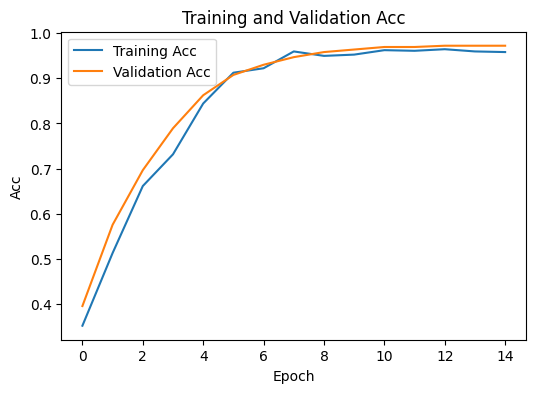

In [23]:
plot_training_accuracy(history)

In [24]:
pred = Tfidf_ANN.predict(X_test)

y_pred = np.argmax(pred, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
0.9617977528089887


<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        IF YOU LIKED THE NOTEBOOK PLEASE DO UPVOTE!  
    </h2>
    </div>